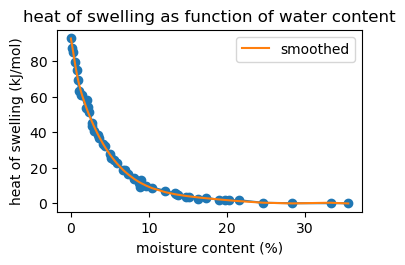

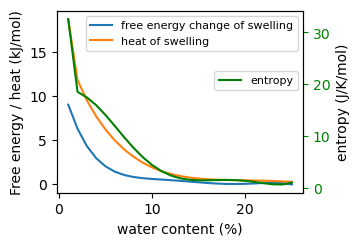

In [108]:
import pandas 
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splrep
from scipy.interpolate import splev

import matplotlib.pyplot as plt
import numpy as np

wetting_url = "https://github.com/yoshi-CERMAV/carbohydrate_polymer2023_data/raw/main/heat_of_wetting.dat"
cotton_isotherm_url = "https://github.com/yoshi-CERMAV/carbohydrate_polymer2023_data/raw/main/cotton_sorption.dat"
df = pandas.read_csv(wetting_url, sep=' ', skiprows=1, header=None, index_col=0) #heat of wetting per g of cotton
df.columns = {"heat"}
cal2kJ = 4.1868 * 1e-3
water_molar_mass = 18
A = cal2kJ*100*water_molar_mass
# cal2kJ*100*water_molar_mass #100 to convert g of cotton to g of water 
df["heat"]=df["heat"] 
df1 = pandas.read_csv(cotton_isotherm_url, sep=' ', skiprows=2, header=None, index_col=0)
X = np.linspace(0, 25, num=101)
t = np.linspace(-1, 25, num=14)
X1= df.index.values #moisture content
Y1= df["heat"].values   
#heat of wettig as function of water content (cal/g)-> (kJ/mol), 100 to convert % to g and 18 to convert g to mol
smoothing_factor = 1.7
splH = splrep(X1, Y1, k=5, s = smoothing_factor)#), s = smoothing_factor)#UnivariateSpline(X1,Y1,k=5,s=smoothing_factor) #enthalpy as function of moiture content
#splHd = splH.derivative()#enthalpy increment per mol water at a given moistur content

data= np.zeros((2,25))
for j in range (0, 25): #moisture content times 1
    for i in range (0,2):
        ip = CubicSpline(df1.index, df1.iloc[:,i].fillna(0).values-j-1.) 
        #find relative humidity at moisture content
        t = ip.roots(extrapolate=False)
        if(t.size):
            data[i,j]=t[0]
        else:
            data[i,j]=np.nan
            
R = 8.31446261815324 #gas constant
temperature = 300 #in Kelvin
kJ=0.001;
water_mw= 18

df2 = pandas.DataFrame(-R * temperature * kJ * np.log(data.T), 
                       index = np.linspace(1,25, num=25))
X=df2.index.values[:,] #moisture content
Y=df2.iloc[:,0].values #equilibrium relative humidity
smoothing_factor = .2
spl1 = UnivariateSpline(X,Y, k=5,s=smoothing_factor) 
gibbs = spl1(X)
heat = splev(X, splH, der=1)*A

#spl2 = UnivariateSpline(X,Y2,s=smoothing_factor)
fig1, ax1 = plt.subplots(figsize=(10*cm, 6*cm))
plt.title("heat of swelling as function of water content")
plt.xlabel("moisture content (%)")
plt.ylabel("heat of swelling (kJ/mol)")
Y1=Y1*A
plt.plot(X1,Y1)
plt.scatter(X1,Y1)
smoothed = splev(X1, splH)*A
plt.plot (X1, smoothed,label="smoothed")
plt.legend()
            
cm = 1/2.54
fig, ax = plt.subplots(figsize=(10*cm, 6*cm))
axes = [ax, ax.twinx()]
fig.subplots_adjust(right=0.75)
axes[1].tick_params(axis='y', colors='green')
axes[0].plot(X, gibbs, label = "free energy change of swelling")
axes[0].plot(X, -heat, label = "heat of swelling") 
axes[1].plot(X, -(heat+gibbs)/temperature*1000, label ="entropy" ,color = 'green') #converting kJ to J
axes[0].set_xlabel("water content (%)")
axes[0].set_ylabel("Free energy / heat (kJ/mol)")
axes[1].set_ylabel("entropy (J/K/mol)")
axes[0].legend(bbox_to_anchor=(1.0, 1), loc='upper right', fontsize="8")
axes[1].legend(bbox_to_anchor=(1.0, .7), fontsize="8")